In [1]:
%pylab inline
import pylab as pl
import pandas as pd
import numpy as np
from sklearn import preprocessing
import geopandas as gp
import zipfile
import os
import scipy.stats
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
pd.set_option('display.max_columns', 30)
pl.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


### Instructions

1. get and prep your data.
2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
4. Use another clustering algorithm (of your choice)
5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
6. Compare the results of the 2 algorithms
7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator.

In [2]:
#import zip code data
zipcodes = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
zipcodes1 = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
zipcodes = pd.DataFrame({'ZIP': zipcodes['postalCode'].astype(int)})

zipjoin = zipcodes.drop_duplicates().sort(columns='ZIP')

/Users/jgrundy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [3]:
#import and merge data
years = [94, 95, 96, 97, 98, 99, 0, 1, 2, 3, 4, 5 ,6, 7, 8, 9, 10, 11, 12, 13]

for i in range(len(years)):
    fname = 'zbp%02dtotals.zip' % years[i]
    
    zf = zipfile.ZipFile(fname)
    data = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    try:
        data = pd.DataFrame({('19%02d' if years[i] > 90 else '20%02d') % years[i]: data['EST'], 'ZIP': data['ZIP']})
    except:
        data = pd.DataFrame({('19%02d' if years[i] > 90 else '20%02d') % years[i]: data['est'], 'ZIP': data['zip']})
    
    zipjoin = zipjoin.merge(data,on='ZIP',how='left')

zipjoin.head()

,ZIP,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
2,10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
3,10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
4,10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479


In [4]:
#data cleaning
zipfinal = zipjoin.dropna()
zipfinal = zipfinal.set_index('ZIP')
zipfinal.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
ZIP,,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296


In [5]:
#data normalization
matrix = zipfinal.as_matrix()
plotdata = (matrix - matrix.mean(axis=1)[:,None]) / (matrix.std(axis=1)[:,None])
print plotdata

[[-1.83163152 -1.17325024 -1.26941829 ..., -0.14499183 -0.08581149
   0.19529512]
 [-1.7228135  -1.63190671 -1.37217303 ...,  1.20698241  1.31607056
   1.40438001]
 [-1.8725281  -1.45724969 -1.31996757 ...,  1.22661573  1.41537864
   1.63159798]
 ..., 
 [-0.41203569 -0.67616114 -0.78181131 ...,  1.48966751  1.38401733
   1.27836715]
 [-0.81500559 -1.36036249 -1.23917207 ...,  1.12404117  1.12404117
   1.18463638]
 [-1.54935655 -1.72442508 -1.37428801 ...,  0.72653443  1.25174003
  -0.32387679]]


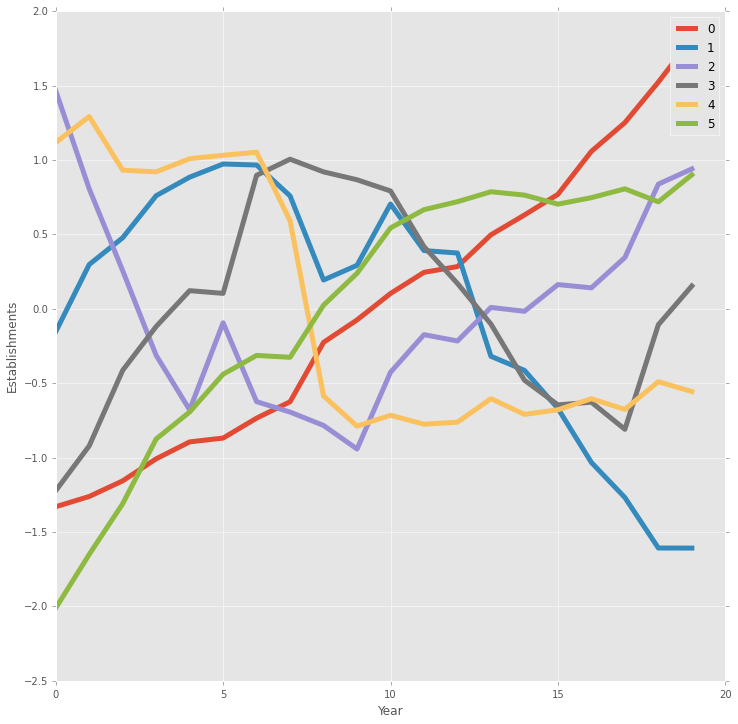

In [15]:
#k-means clustering
plt.figure(figsize=(12,12))

n_cluster = 6
kmeans = KMeans(n_clusters=n_cluster).fit(plotdata)

for i in range(n_cluster):
    pl.plot(kmeans.cluster_centers_[i], label = i, lw = 5)

pl.legend(loc='upper right')
pl.xlabel('Year')
pl.ylabel('Establishments')

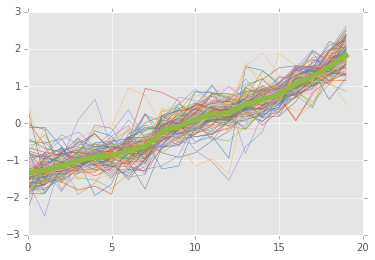

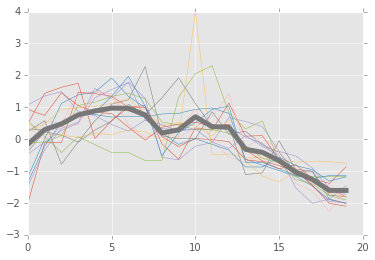

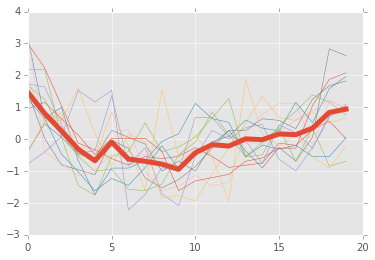

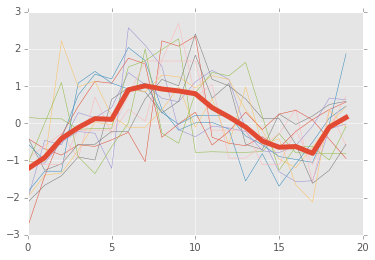

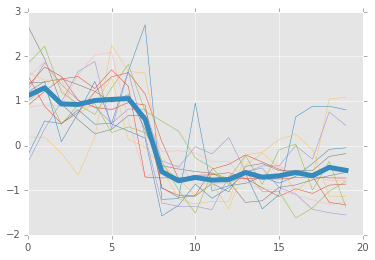

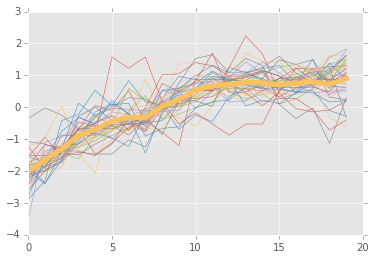

In [16]:
for j in range(kmeans.n_clusters):
    index = kmeans.labels_ == j
    pl.figure()
    for i in range (0, len(plotdata)):
        if index[i] == True:   
            pl.plot(plotdata[i], lw = 0.5)
    pl.plot(kmeans.cluster_centers_[j], lw = 5)

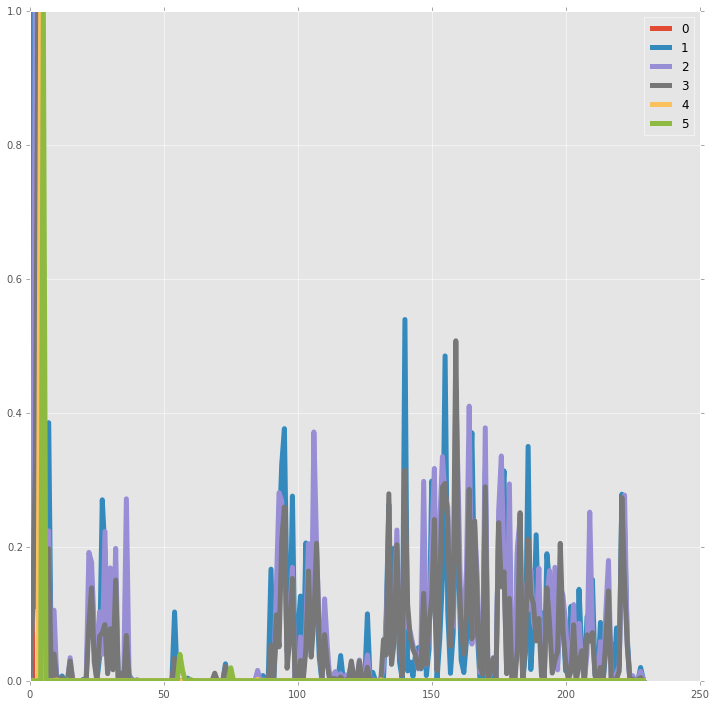

In [46]:
#spectral clustering
plt.figure(figsize=(12,12))

n_cluster = 6
spec_clus = SpectralClustering(n_clusters=n_cluster, assign_labels='discretize').fit(plotdata)

for i in range(n_cluster):
    pl.plot(spec_clus.affinity_matrix_[i], label = i, lw = 5)

pl.legend(loc='upper right')

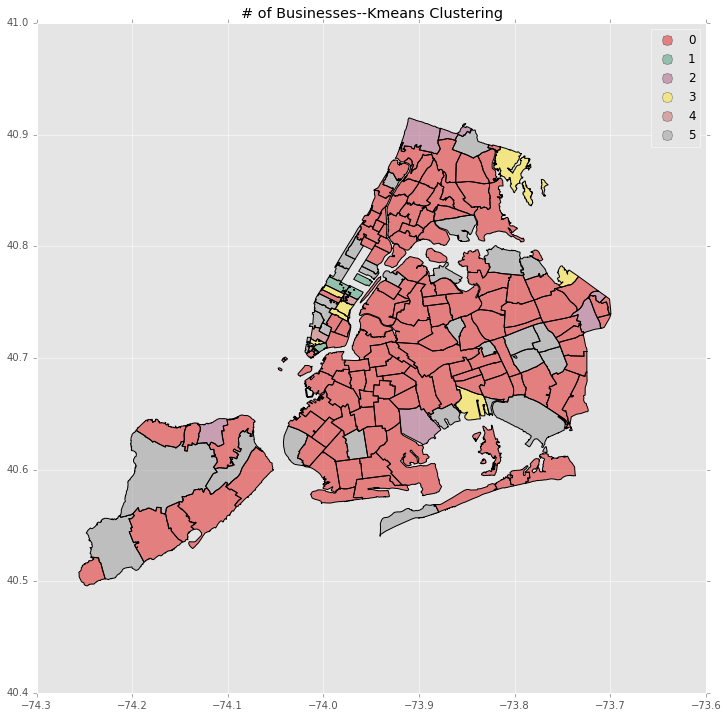

In [27]:
#Putting the clusters into a geodataframe
zipcodes1['postalCode'] = zipcodes1['postalCode'].astype(float)

# Setup label data to be merged
zipfinal['label'] = kmeans.labels_
zipfinal['ZIP'] = zipfinal.index

# Merge
merged = zipcodes1.merge(zipfinal, left_on='postalCode', right_on='ZIP')

# Plot
figure, ax = pl.subplots(figsize=(12,12))
merged.plot(axes=ax, column='label', legend=True, categorical=True)
ax.set_title('# of Businesses--Kmeans Clustering')

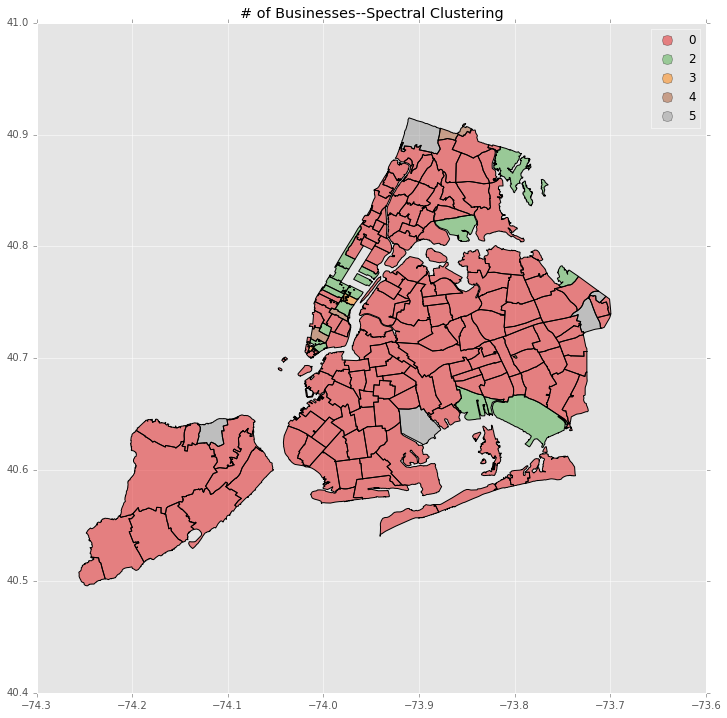

In [47]:
#Putting the clusters into a geodataframe
zipcodes1['postalCode'] = zipcodes1['postalCode'].astype(float)

# Setup label data to be merged
zipfinal['label'] = spec_clus.labels_
zipfinal['ZIP'] = zipfinal.index

# Merge
merged1 = zipcodes1.merge(zipfinal, left_on='postalCode', right_on='ZIP')

# Plot
figure, ax = pl.subplots(figsize=(12,12))
merged1.plot(axes=ax, column='label', legend=True, categorical=True)
ax.set_title('# of Businesses--Spectral Clustering')

## Interpretation
There appears to be some variability between the two algorithms. They're common in that both algorithms capture the fact that the vast majority of the city falls into the same business-development cluster. They also both do a good job at capturing the development of the western park of midtown Manhattan (including Hells Kitchen, etc), and the East Village. However, they diverge from there in the indivdidual other ZIP codes that do or do not get captured in the main cluster for each algorithm.